In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [2]:
images = np.load('numpy_database/images_training_dataset.npy')
segmentations = np.load('numpy_database/segmentations_training_dataset.npy')

images_val = np.load('numpy_database/images_validation_dataset.npy')
segmentations_val = np.load('numpy_database/segmentations_validation_dataset.npy')

images_test = np.load('numpy_database/images_test_dataset.npy')
segmentations_test = np.load('numpy_database/segmentations_test_dataset.npy')

In [3]:
def tensorflow_dataset(images, segmentations, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, segmentations))
    dataset = dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

batch_size = 16
train_dataset = tensorflow_dataset(images, segmentations, batch_size)
val_dataset = tensorflow_dataset(images_val, segmentations_val, batch_size)
test_dataset = tensorflow_dataset(images_test, segmentations_test, batch_size)


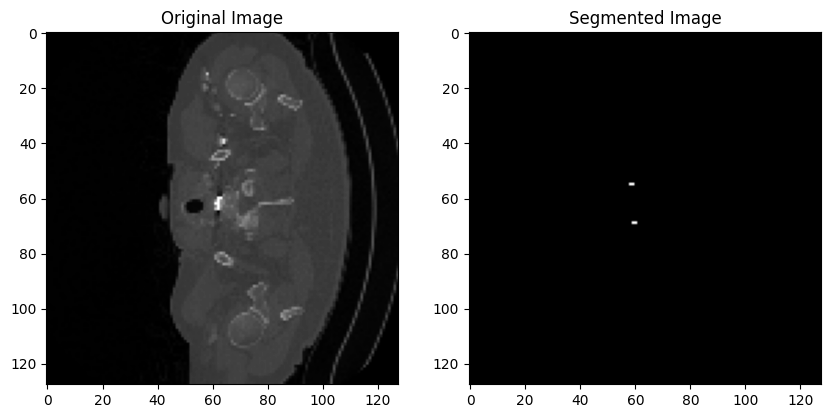

In [4]:
import matplotlib.pyplot as plt

for image, segmentation in train_dataset.take(1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(tf.squeeze(image[0]), cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(tf.squeeze(segmentation[0]), cmap='gray')
    ax[1].set_title('Segmented Image')
    plt.show()

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout

def small_unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.2)(p3)
    
    # Bottleneck
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    # Decoder
    u5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = small_unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [6]:
# Trenowanie modelu
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
205/205 [==============================] - 166s 799ms/step - loss: 0.0454 - accuracy: 0.9949 - val_loss: 0.0110 - val_accuracy: 0.9977
Epoch 2/10
205/205 [==============================] - 166s 807ms/step - loss: 0.0108 - accuracy: 0.9969 - val_loss: 0.0104 - val_accuracy: 0.9977
Epoch 3/10
205/205 [==============================] - 166s 810ms/step - loss: 0.0090 - accuracy: 0.9971 - val_loss: 0.0103 - val_accuracy: 0.9977
Epoch 4/10
205/205 [==============================] - 170s 828ms/step - loss: 0.0079 - accuracy: 0.9975 - val_loss: 0.0086 - val_accuracy: 0.9980
Epoch 5/10
205/205 [==============================] - 172s 841ms/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 0.0099 - val_accuracy: 0.9981
Epoch 6/10
205/205 [==============================] - 175s 856ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.0077 - val_accuracy: 0.9982
Epoch 7/10
205/205 [==============================] - 173s 844ms/step - loss: 0.0049 - accuracy: 0.9984 - val_loss: 0.0069 -

55/55 [==============================] - 12s 227ms/step - loss: 0.0079 - accuracy: 0.9978
Evaluation loss: 0.007922464981675148
Evaluation accuracy: 0.9977636337280273
1/1 [==============================] - 0s 458ms/step


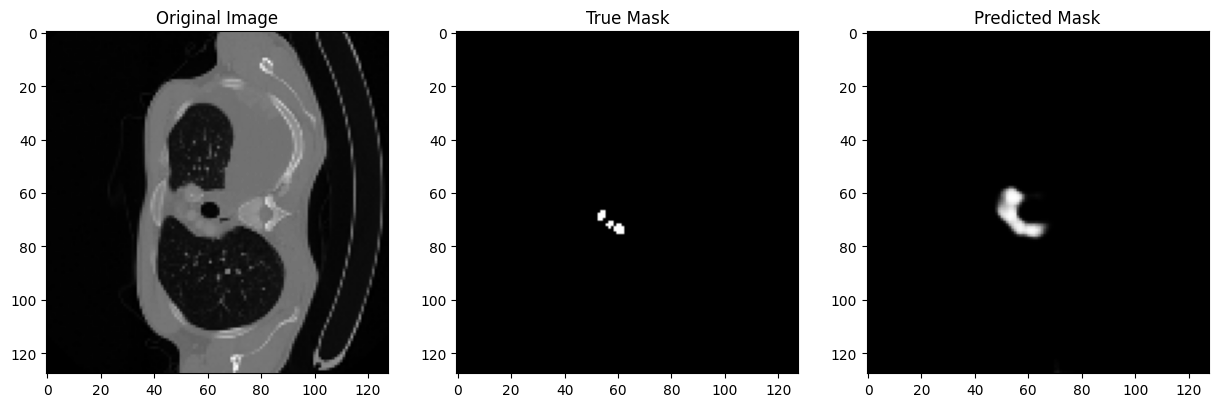

1/1 [==============================] - 0s 236ms/step


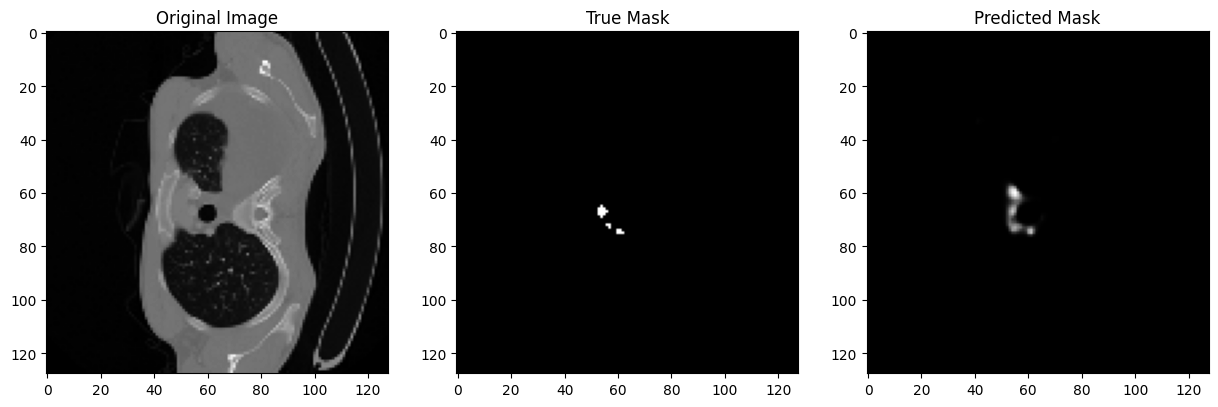

1/1 [==============================] - 0s 219ms/step


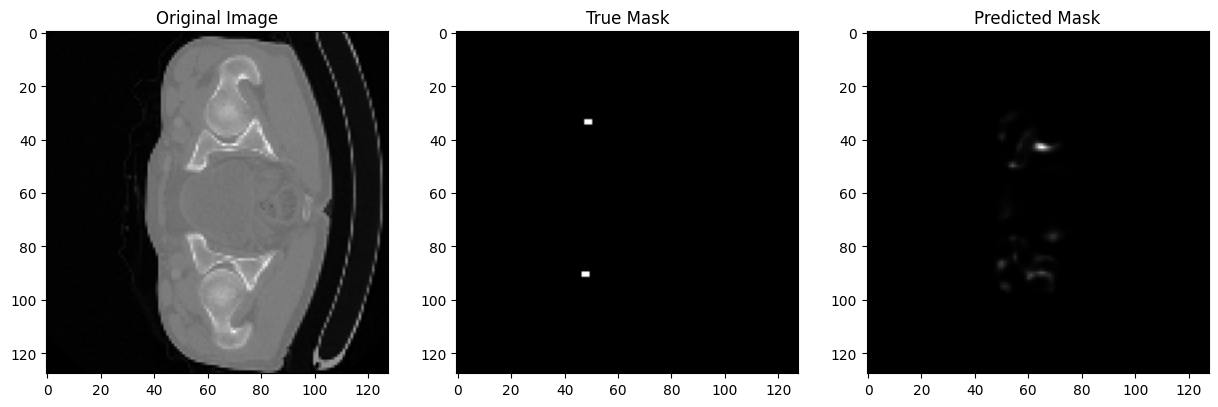

1/1 [==============================] - 0s 219ms/step


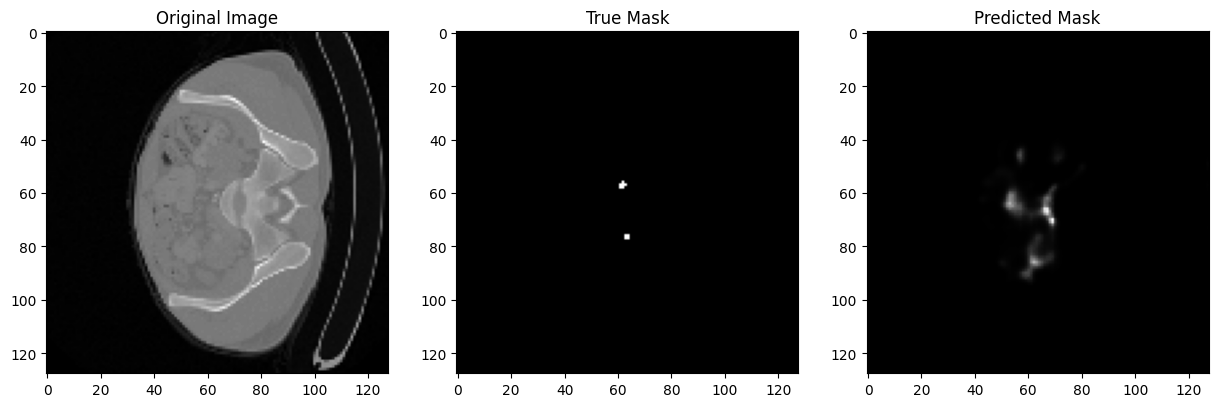

1/1 [==============================] - 0s 203ms/step


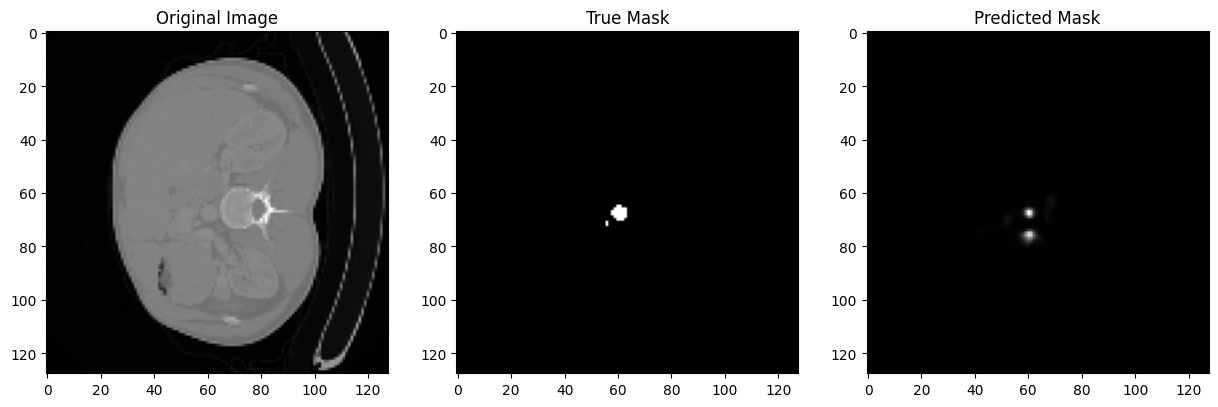

1/1 [==============================] - 0s 203ms/step


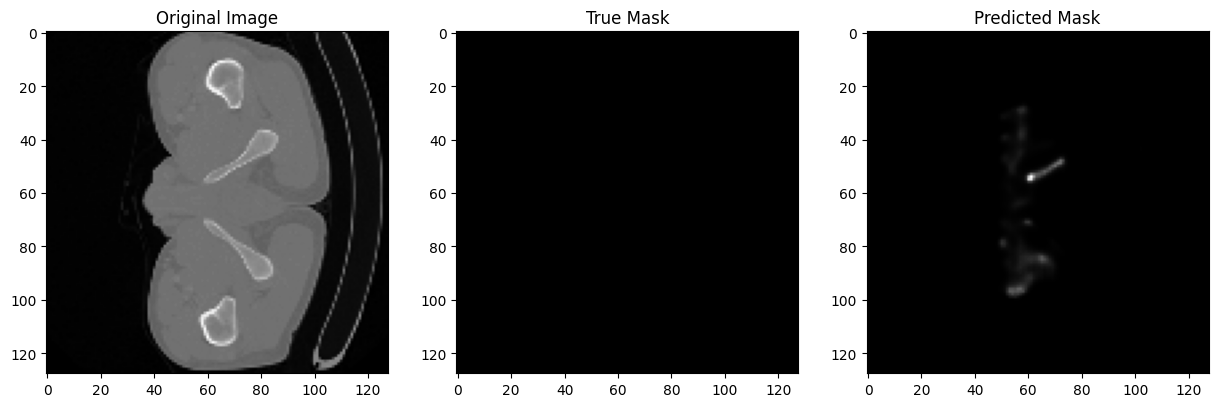

1/1 [==============================] - 0s 203ms/step


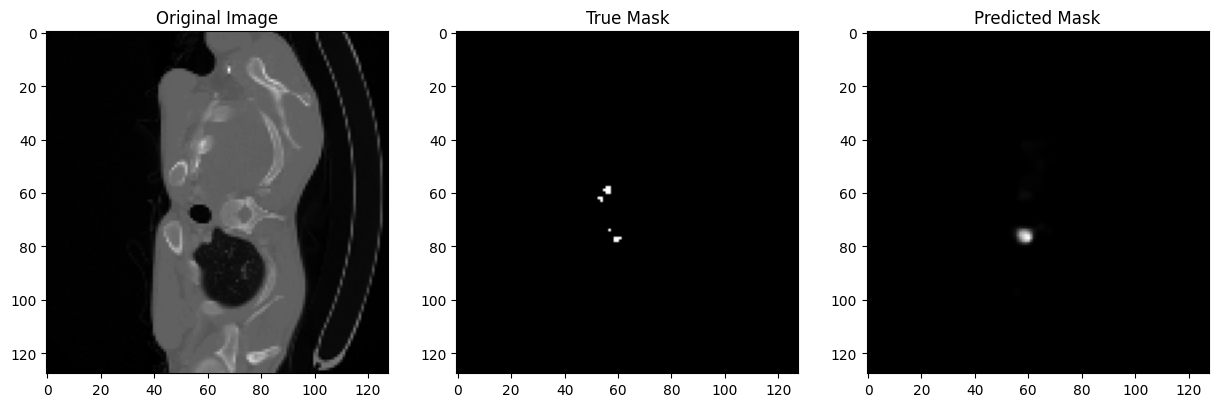

1/1 [==============================] - 0s 200ms/step


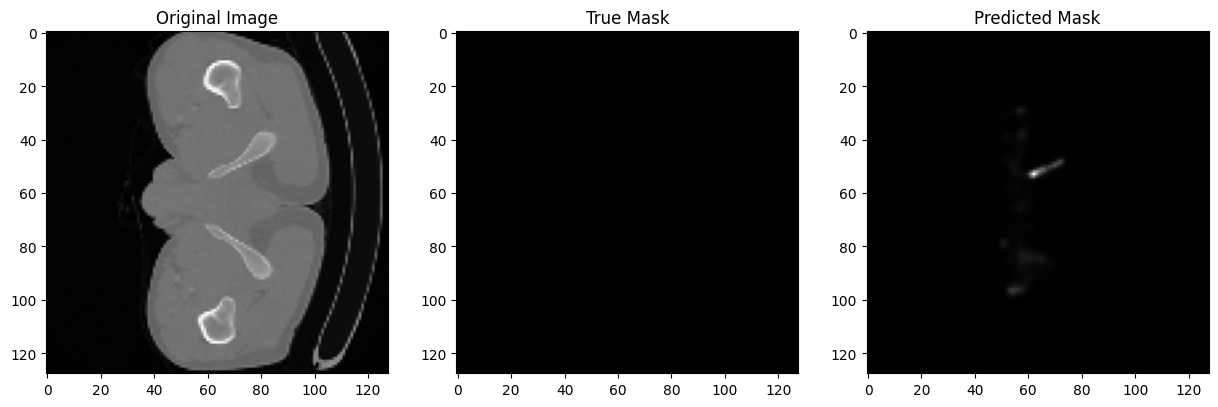

1/1 [==============================] - 0s 200ms/step


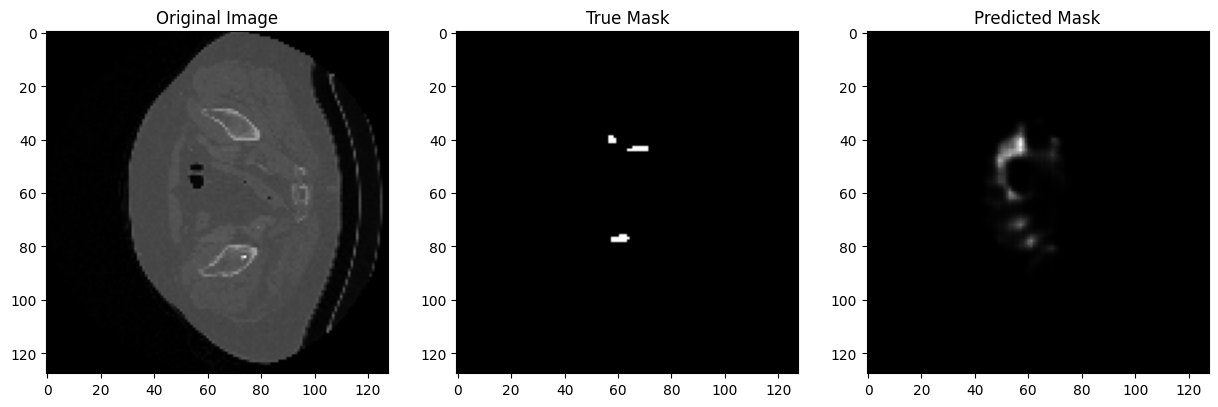

1/1 [==============================] - 0s 205ms/step


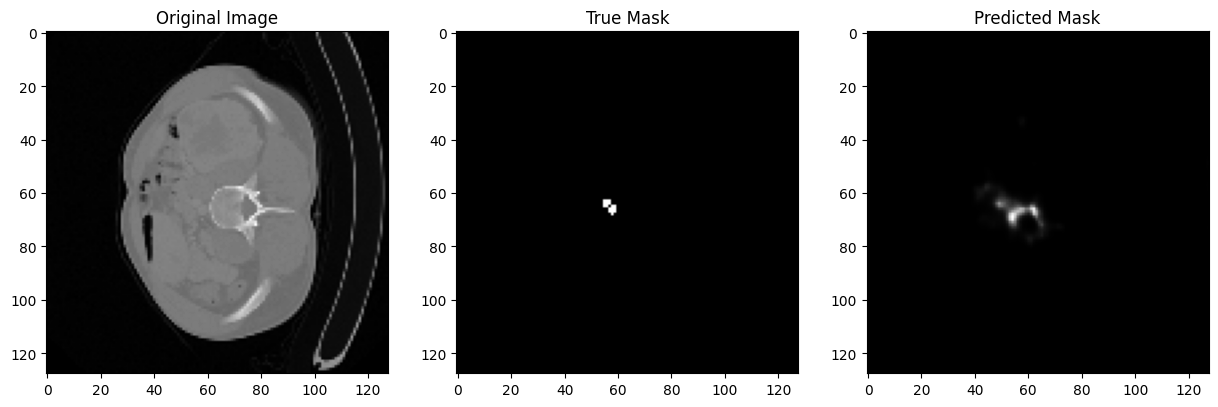

In [7]:
# Ewaluacja modelu
loss, accuracy = model.evaluate(val_dataset)
print(f'Evaluation loss: {loss}')
print(f'Evaluation accuracy: {accuracy}')

# Wyświetlanie przykładowych wyników
for image, true_mask in val_dataset.take(10):
    pred_mask = model.predict(image)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(tf.squeeze(image[0]), cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(tf.squeeze(true_mask[0]), cmap='gray')
    ax[1].set_title('True Mask')
    ax[2].imshow(tf.squeeze(pred_mask[0]), cmap='gray')
    ax[2].set_title('Predicted Mask')
    plt.show()


55/55 [==============================] - 11s 191ms/step - loss: 0.0079 - accuracy: 0.9978
Validation Loss: 0.007922465912997723
Validation Accuracy: 0.9977636337280273


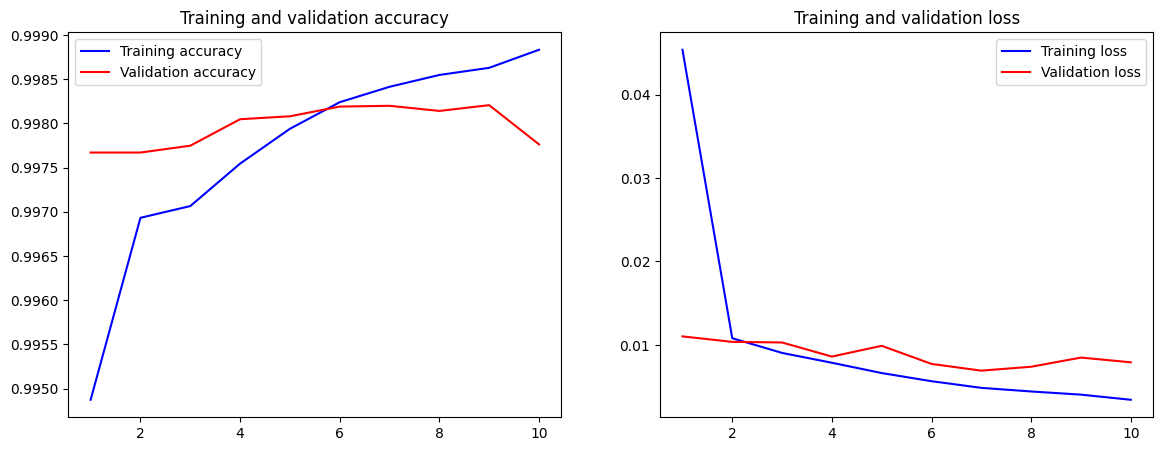

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Visualize the training results
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)


In [9]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

78/78 [==============================] - 15s 187ms/step - loss: 0.0064 - accuracy: 0.9981
Test Loss: 0.006448004394769669
Test Accuracy: 0.998130202293396


In [10]:
# Save and export the model
model_save_path = 'Saved_Models/Small_unet_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to Saved_Models/Small_unet_model.h5


1/1 [==============================] - 0s 113ms/step


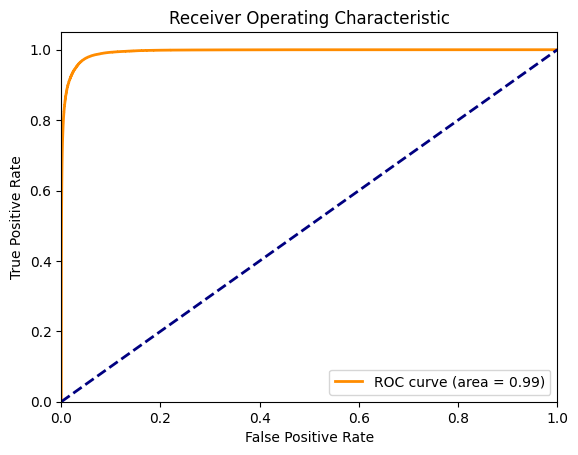

AUC: 0.9943
Dice Coefficient: 0.6123
Hausdorff Distance: 10.8139


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.spatial.distance import directed_hausdorff
import tensorflow as tf

# Assuming 'model' is your trained model and 'test_dataset' is your test data
# Step 1: Get predictions
y_true = []
y_pred = []

for images, masks in test_dataset:
    y_true.append(masks.numpy())
    preds = model.predict(images)
    y_pred.append(preds)

y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# Flatten the arrays for ROC and AUC computation
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Step 2: Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true_flat, y_pred_flat)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Step 3: Calculate Dice coefficient
def dice_coefficient(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

dice = dice_coefficient(y_true, y_pred)

# Step 4: Calculate Hausdorff Distance
def hausdorff_distance(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.float32)
    hausdorff_dist = []
    for i in range(y_true.shape[0]):
        true_points = np.argwhere(y_true[i])
        pred_points = np.argwhere(y_pred[i])
        if true_points.size == 0 or pred_points.size == 0:
            continue  # Avoid cases with empty sets
        forward_hausdorff = directed_hausdorff(true_points, pred_points)[0]
        backward_hausdorff = directed_hausdorff(pred_points, true_points)[0]
        hausdorff_dist.append(max(forward_hausdorff, backward_hausdorff))
    return np.mean(hausdorff_dist)

hausdorff = hausdorff_distance(y_true, y_pred)

print(f'AUC: {roc_auc:.4f}')
print(f'Dice Coefficient: {dice:.4f}')
print(f'Hausdorff Distance: {hausdorff:.4f}')